In [1]:
from tournament.agents.constant import AllC, AllD
from tournament.agents.pavlov import Pavlov
from tournament.agents.q_learning.dqn import DeepQLearner
from tournament.agents.tft import TFTT, GenerousTFT, TitForTat
from tournament.environments.single import SingleRuleBasedAgentEnvironment
from tournament.environments.multiple import MultipleRuleBasedAgentEnvironment
from tournament.action import Action
from tournament.agents.agents import AGENTS
from tournament.agents.axelrod_first import (
    Davis,
    Downing,
    Feld,
    Grofman,
    Grudger,
    Joss,
    Nydegger,
    Shubik,
    SteinAndRapoport,
    TidemanAndChieruzzi,
    Tullock,
)
from tournament.agents.tft import (
    TFTT,
    TTFT,
    GenerousTFT,
    GradualTFT,
    OmegaTFT,
    TitForTat,
)
from tournament.tournament import RoundRobinTournament

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# env = SingleRuleBasedAgentEnvironment(TitForTat)
env = MultipleRuleBasedAgentEnvironment([
    TitForTat,
    # AllC,
    TFTT,
    TTFT,
    GenerousTFT,
    # GradualTFT,
    OmegaTFT,
    Davis,
    # Downing,
    # Feld,
    Grofman,
    # Grudger,
    # Joss,
    # Nydegger,
    # Shubik,
    SteinAndRapoport,
    # TidemanAndChieruzzi,
    # Tullock,
    # Pavlov
])

In [3]:
class QNetwork(nn.Module):
    def __init__(self, lookback):
        super().__init__()

        # self.elu = nn.ELU()

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(2 * lookback, 100)
        self.layer2 = nn.Linear(100, 100)
        # self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(100, 2)

        nn.init.kaiming_uniform_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        # nn.init.kaiming_uniform_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.unsqueeze(dim=0)
        x = self.flatten(x)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        # x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))

        return x

class QLearningTest(DeepQLearner):
    lookback = 8
    epsilon = 0.25

    def __init__(self):
        super().__init__()

        self._learning_rate = 0.05
        self._discount_rate = 0.95
        self._q_network = QNetwork(self.lookback)


agent = QLearningTest()

In [4]:
env.train(
    trainee=agent,
    continuation_probability=1,
    limit=200,
    noise=0,
    repetitions=1,
    epochs=100,
)

[14:55:51] Commencement of training.
[14:56:00] Completed epoch 1: 2.1245699495141164
[14:56:07] Completed epoch 2: 1.9940037247570581
[14:56:13] Completed epoch 3: 2.0358983165047055
[14:56:21] Completed epoch 4: 2.056142487378529
[14:56:27] Completed epoch 5: 2.073413989902823
[14:56:33] Completed epoch 6: 2.0388345749190195
[14:56:40] Completed epoch 7: 2.044402849930588
[14:56:47] Completed epoch 8: 2.0522118686892643
[14:56:54] Completed epoch 9: 2.0591536055015687
[14:57:01] Completed epoch 10: 2.0408319949514118
[14:57:07] Completed epoch 11: 2.048881359046738
[14:57:14] Completed epoch 12: 2.0553547874595095
[14:57:20] Completed epoch 13: 2.062899611501086
[14:57:27] Completed epoch 14: 2.0701478535367226
[14:57:34] Completed epoch 15: 2.073283829967608
[14:57:40] Completed epoch 16: 2.078449684344632
[14:57:47] Completed epoch 17: 2.0831364676184774
[14:57:54] Completed epoch 18: 2.08700735830634
[14:58:01] Completed epoch 19: 2.072510260500743
[14:58:09] Completed epoch 20: 2

In [5]:
print(agent._q_network)
print(env.counts)

s = sum(env.counts.values())
print({a: env.counts[a] / s for a in env.counts})

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=2, bias=True)
)
{<Action.COOPERATE: 0>: 140000, <Action.DEFECT: 1>: 20000}
{<Action.COOPERATE: 0>: 0.875, <Action.DEFECT: 1>: 0.125}


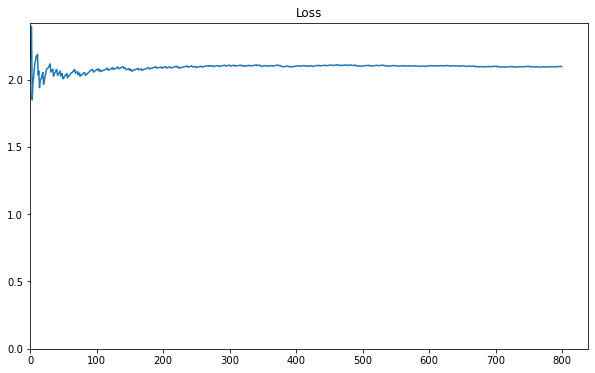

In [6]:
plt.title("Loss")
plt.plot(env.metric_history)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

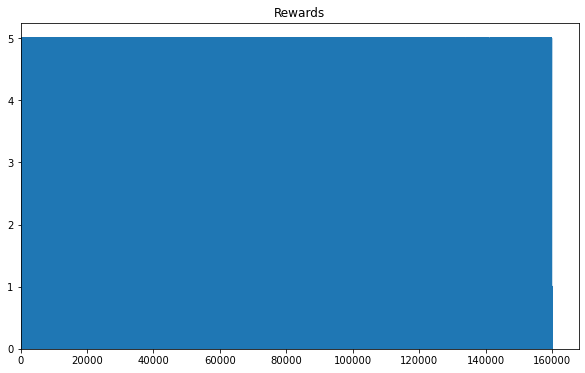

In [7]:
plt.title("Rewards")
plt.plot(env.rewards)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

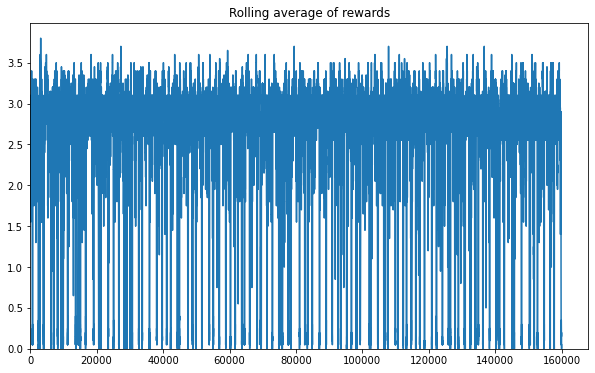

In [8]:
N = 20

plt.title("Rolling average of rewards")
plt.plot(np.convolve(env.rewards, np.ones(N), mode='valid') / N)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

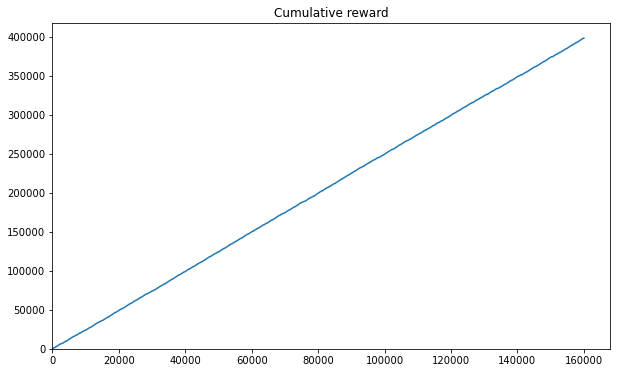

In [9]:
plt.title("Cumulative reward")
plt.plot(np.cumsum(env.rewards))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

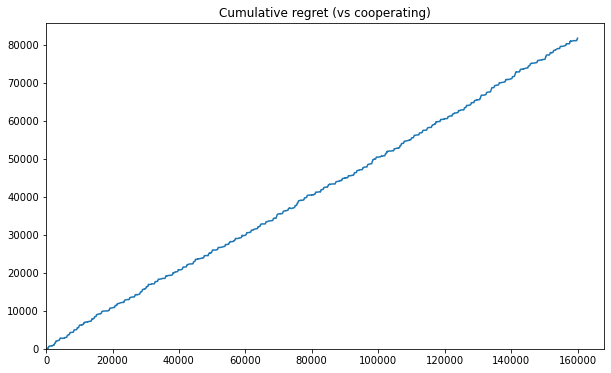

In [10]:
plt.title("Cumulative regret (vs cooperating)")
plt.plot(np.cumsum(3 - np.array(env.rewards)))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

[{<Action.COOPERATE: 0>: 0.88, <Action.DEFECT: 1>: 0.12}, {<Action.COOPERATE: 0>: 0.864375, <Action.DEFECT: 1>: 0.135625}, {<Action.COOPERATE: 0>: 0.8775, <Action.DEFECT: 1>: 0.1225}, {<Action.COOPERATE: 0>: 0.87, <Action.DEFECT: 1>: 0.13}, {<Action.COOPERATE: 0>: 0.88625, <Action.DEFECT: 1>: 0.11375}, {<Action.COOPERATE: 0>: 0.883125, <Action.DEFECT: 1>: 0.116875}, {<Action.COOPERATE: 0>: 0.88125, <Action.DEFECT: 1>: 0.11875}, {<Action.COOPERATE: 0>: 0.86125, <Action.DEFECT: 1>: 0.13875}, {<Action.COOPERATE: 0>: 0.88375, <Action.DEFECT: 1>: 0.11625}, {<Action.COOPERATE: 0>: 0.8675, <Action.DEFECT: 1>: 0.1325}, {<Action.COOPERATE: 0>: 0.874375, <Action.DEFECT: 1>: 0.125625}, {<Action.COOPERATE: 0>: 0.883125, <Action.DEFECT: 1>: 0.116875}, {<Action.COOPERATE: 0>: 0.870625, <Action.DEFECT: 1>: 0.129375}, {<Action.COOPERATE: 0>: 0.88, <Action.DEFECT: 1>: 0.12}, {<Action.COOPERATE: 0>: 0.88, <Action.DEFECT: 1>: 0.12}, {<Action.COOPERATE: 0>: 0.86875, <Action.DEFECT: 1>: 0.13125}, {<Action.

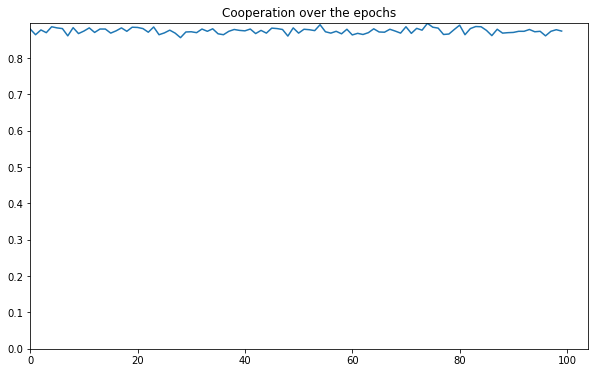

In [11]:
plt.title("Cooperation over the epochs")
print(env.normalised_epoch_counts)
plt.plot([x[Action.COOPERATE] for x in env.normalised_epoch_counts])
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [12]:
# torch.save(agent._q_network.state_dict(), "model.pt")

In [13]:
agent._q_network.eval()

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=2, bias=True)
)

In [14]:
tournament = RoundRobinTournament(AGENTS, [agent])

scores, times = tournament.play(
    continuation_probability=0.99654, repetitions=20, jobs=12
)

results = [
    (agent, round(sum(scores[agent]) / len(scores[agent])), sum(times[agent]))
    for agent in scores
]
results.sort(key=lambda x: x[1], reverse=True)

for c, score, time in results:
    print(f"{c.__name__:<30} {score:<20} {time:<20}")


100%|██████████| 961/961 [01:35<00:00, 10.03matches/s] 

GraaskampAndKatzen        805                  10.06714            
Leyvraz                        796                  39.965382           
GenerousTFT                    788                  6.732829000000001   
Davis                          787                  13.465391999999998  
SecondByBlackK83R              786                  11.407582000000001  
GradualTFT                     783                  96.971239           
Grudger                        780                  7.8192270000000015  
TTFT                           777                  7.757298999999999   
Shubik                         776                  7.478555999999998   
OmegaTFT                       776                  9.367633            
Pavlov                         773                  7.466087999999998   
White              770                  9.15299             
TitForTat                      769                  7.104551999999999   
Weiner                 761                  21.348224000000005  
Ste